<a href="https://colab.research.google.com/github/dustoff06/FERP/blob/main/FERP_Copula.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
import numpy as np
import pandas as pd
from scipy.stats import kendalltau

def estimate_gumbel_theta(rankings):
    """
    Estimate the Gumbel copula parameter theta from Kendall's tau.
    Uses the strongest dependence instead of averaging.
    """
    n = len(rankings)
    taus = []

    for i in range(n):
        for j in range(i+1, n):
            tau, _ = kendalltau(rankings[i], rankings[j])
            taus.append(tau)

    max_tau = max(taus)  # Use the strongest dependency
    theta = max(1.05, 1 / (1 - max_tau)) if max_tau < 1 else 10

    return theta

def gumbel_copula_sample(theta, num_samples, dim=3):
    """
    Generate dependent samples from a Gumbel copula with stronger tail dependence.
    """
    V = np.random.gamma(1/theta, 1, num_samples)  # Stable variable
    E = -np.log(np.random.uniform(size=(num_samples, dim)))  # Exponential samples
    X = E / V[:, np.newaxis]  # Scale samples
    U = np.exp(-X**(1/theta))  # Transform to uniform

    return np.clip(U, 1e-6, 1 - 1e-6)  # Avoid numerical issues

def rank_to_uniform(rankings):
    """
    Convert rankings to uniform [0,1] variables using a robust transformation.
    """
    n = len(rankings)
    ranks = pd.Series(rankings).rank(method='average')
    return np.array((ranks - 0.5) / n)  # Adjusted to prevent ties at 0 or 1

def gumbel_copula_monte_carlo(rankings1, rankings2, rankings3, num_samples=10000):
    """
    Computes the Gumbel-based joint probability using Monte Carlo approximation.
    """
    df_rankings = pd.DataFrame({'rank1': rankings1, 'rank2': rankings2, 'rank3': rankings3})
    n_items = len(rankings1)

    if np.any(df_rankings.nunique() < n_items * 0.8):
        print("⚠️ Warning: Some rankings may contain too many ties!")

    # Estimate copula dependence parameter θ (choose the strongest dependency)
    theta = estimate_gumbel_theta([rankings1, rankings2, rankings3])

    # Generate dependent Gumbel copula samples
    gumbel_samples = gumbel_copula_sample(theta, num_samples, dim=3)

    # Convert rankings to uniform [0,1] using percentile-based transformation
    U1 = rank_to_uniform(rankings1)
    U2 = rank_to_uniform(rankings2)
    U3 = rank_to_uniform(rankings3)

    # Initialize arrays for probabilities
    joint_prob = np.zeros(n_items)
    cond_prob_1 = np.zeros(n_items)
    cond_prob_2 = np.zeros(n_items)
    cond_prob_3 = np.zeros(n_items)

    epsilon = 1e-6  # Small value to prevent division errors

    # For each data point, compute probabilities
    for i in range(n_items):
        # Joint probability: P(U1 ≤ u1, U2 ≤ u2, U3 ≤ u3)
        joint = (gumbel_samples[:, 0] <= U1[i]) & (gumbel_samples[:, 1] <= U2[i]) & (gumbel_samples[:, 2] <= U3[i])
        joint_prob[i] = np.mean(joint)

        # Conditional probability: P(U1 ≤ u1 | U2 ≤ u2, U3 ≤ u3)
        condition_2_3 = (gumbel_samples[:, 1] <= U2[i]) & (gumbel_samples[:, 2] <= U3[i])
        cond_prob_1[i] = np.sum(joint) / (np.sum(condition_2_3) + epsilon)

        # Conditional probability: P(U2 ≤ u2 | U1 ≤ u1, U3 ≤ u3)
        condition_1_3 = (gumbel_samples[:, 0] <= U1[i]) & (gumbel_samples[:, 2] <= U3[i])
        cond_prob_2[i] = np.sum(joint) / (np.sum(condition_1_3) + epsilon)

        # Conditional probability: P(U3 ≤ u3 | U1 ≤ u1, U2 ≤ u2)
        condition_1_2 = (gumbel_samples[:, 0] <= U1[i]) & (gumbel_samples[:, 1] <= U2[i])
        cond_prob_3[i] = np.sum(joint) / (np.sum(condition_1_2) + epsilon)

    # Average the conditional probabilities
    conditional_marginals = {
        "P(U1 | U2, U3)": np.mean(cond_prob_1),
        "P(U2 | U1, U3)": np.mean(cond_prob_2),
        "P(U3 | U1, U2)": np.mean(cond_prob_3)
    }

    return joint_prob, conditional_marginals

# Generate synthetic rankings and run Monte Carlo estimation
np.random.seed(42)
n_items = 100
rankings1 = np.random.randint(1, n_items//2, n_items)
rankings2 = rankings1 + np.random.normal(0, 10, n_items)
rankings3 = np.random.permutation(n_items) + 1

joint_prob, conditional_marginals = gumbel_copula_monte_carlo(rankings1, rankings2, rankings3)

print(f"Joint Probability (Gumbel-Copula - Monte Carlo): {joint_prob.mean():.6f}")
print("Conditional Marginals:", conditional_marginals)


⚠️ Warning: Some rankings may contain too many ties!
Joint Probability (Gumbel-Copula - Monte Carlo): 0.592704
Conditional Marginals: {'P(U1 | U2, U3)': 0.9083532160609786, 'P(U2 | U1, U3)': 0.9078031079340451, 'P(U3 | U1, U2)': 0.8548473555591818}


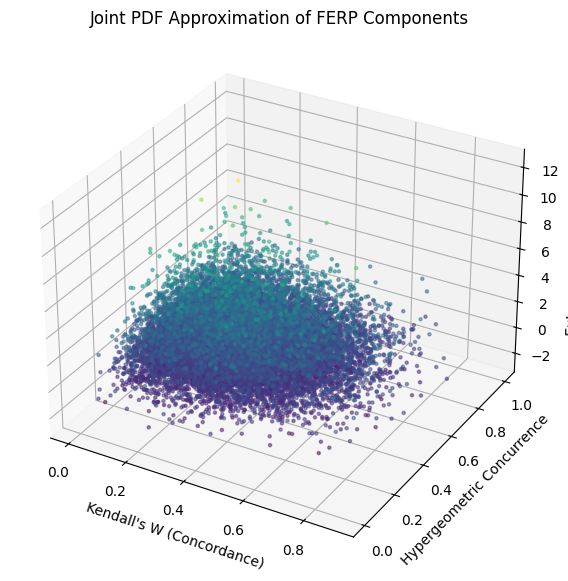

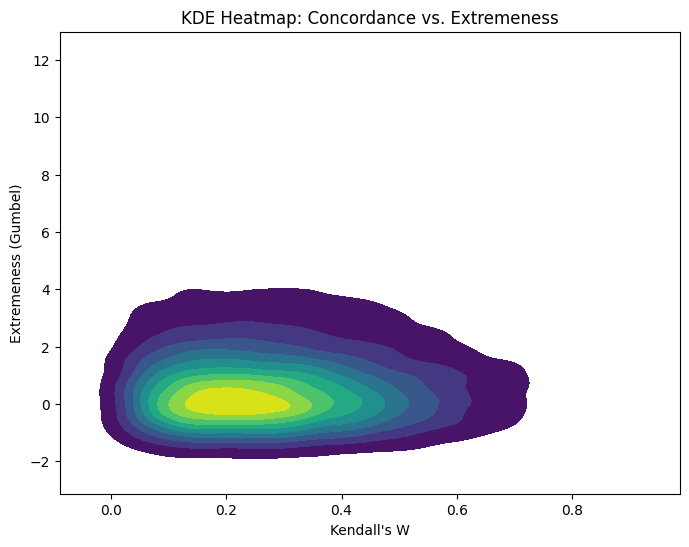

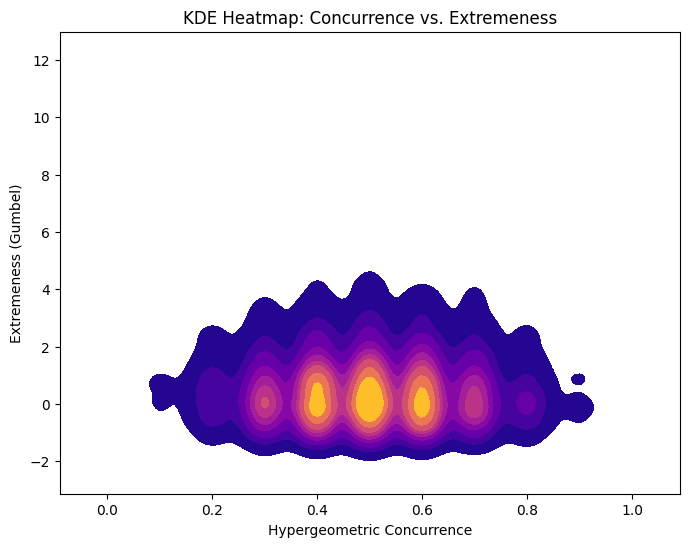

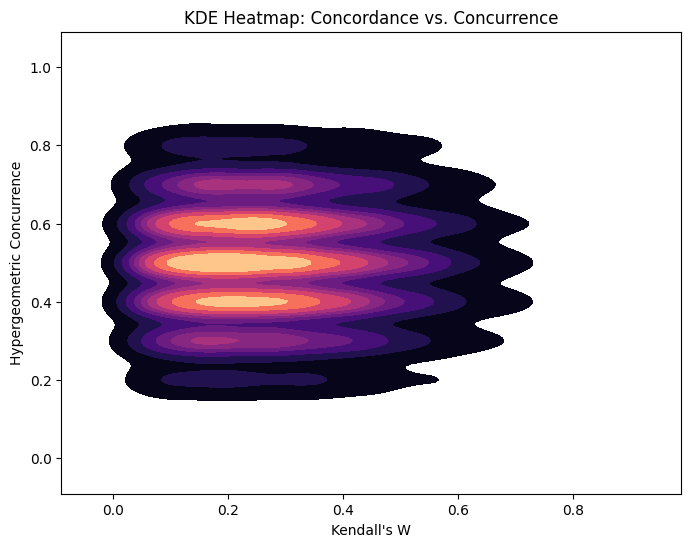

   Kendall_W  Hypergeometric_Concurrence  Extremeness_Gumbel
0   0.564980                         0.5           -1.012811
1   0.300182                         0.6           -0.593592
2   0.499540                         0.0            1.185676
3   0.398783                         0.6           -0.543588
4   0.461575                         0.6           -0.270519


In [19]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D

# Generate Monte Carlo samples
N = 20000  # Number of samples

# Simulate Kendall's W (Concordance) as a beta distribution (approximation)
kendall_w = np.random.beta(a=2, b=5, size=N)  # Adjust shape parameters as needed

# Simulate Hypergeometric Concurrence as a binomial approximation (continuous)
hypergeom_concurrence = np.random.binomial(n=10, p=0.5, size=N) / 10  # Normalized

# Simulate Extremeness using a Gumbel distribution
extremeness_gumbel = np.random.gumbel(loc=0, scale=1, size=N)

# Create a DataFrame for visualization
df = pd.DataFrame({
    'Kendall_W': kendall_w,
    'Hypergeometric_Concurrence': hypergeom_concurrence,
    'Extremeness_Gumbel': extremeness_gumbel
})

# Generate 3D Density Plot (Scatter Approximation)
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot density representation
ax.scatter(df['Kendall_W'], df['Hypergeometric_Concurrence'], df['Extremeness_Gumbel'],
           c=df['Extremeness_Gumbel'], cmap='viridis', alpha=0.5, s=5)

ax.set_xlabel("Kendall's W (Concordance)")
ax.set_ylabel("Hypergeometric Concurrence")
ax.set_zlabel("Extremeness (Gumbel)")
ax.set_title("Joint PDF Approximation of FERP Components")

plt.show()

# Show KDE heatmap for Kendall's W vs. Extremeness (Gumbel)
plt.figure(figsize=(8, 6))
sns.kdeplot(x=df["Kendall_W"], y=df["Extremeness_Gumbel"], fill=True, cmap="viridis")
plt.xlabel("Kendall's W")
plt.ylabel("Extremeness (Gumbel)")
plt.title("KDE Heatmap: Concordance vs. Extremeness")
plt.show()

# Show KDE heatmap for Hypergeometric Concurrence vs. Extremeness (Gumbel)
plt.figure(figsize=(8, 6))
sns.kdeplot(x=df["Hypergeometric_Concurrence"], y=df["Extremeness_Gumbel"], fill=True, cmap="plasma")
plt.xlabel("Hypergeometric Concurrence")
plt.ylabel("Extremeness (Gumbel)")
plt.title("KDE Heatmap: Concurrence vs. Extremeness")
plt.show()

# Show KDE heatmap for Kendall's W vs. Hypergeometric Concurrence
plt.figure(figsize=(8, 6))
sns.kdeplot(x=df["Kendall_W"], y=df["Hypergeometric_Concurrence"], fill=True, cmap="magma")
plt.xlabel("Kendall's W")
plt.ylabel("Hypergeometric Concurrence")
plt.title("KDE Heatmap: Concordance vs. Concurrence")
plt.show()

# Display the generated data
print(df.head())


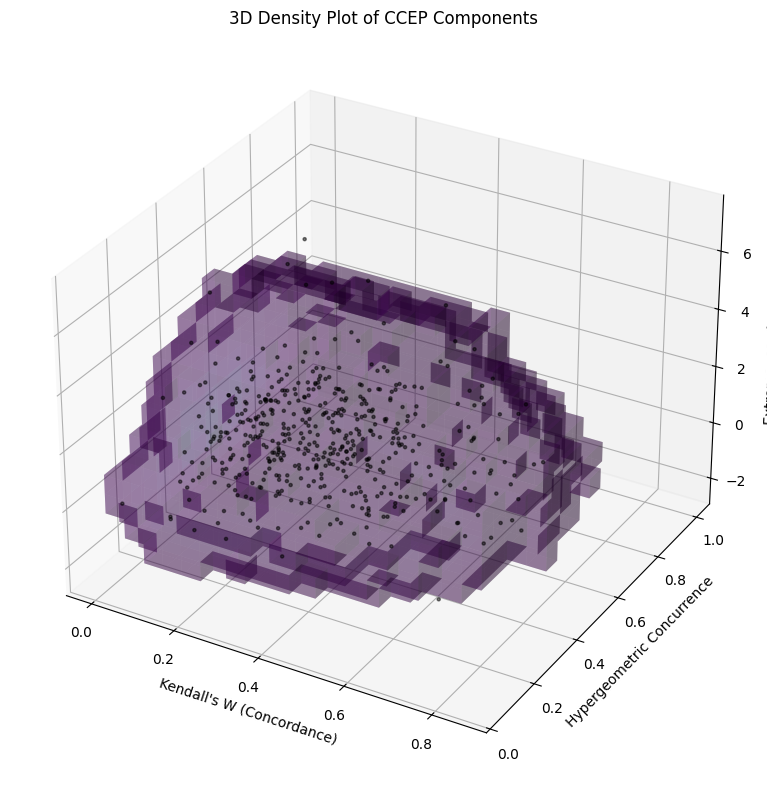

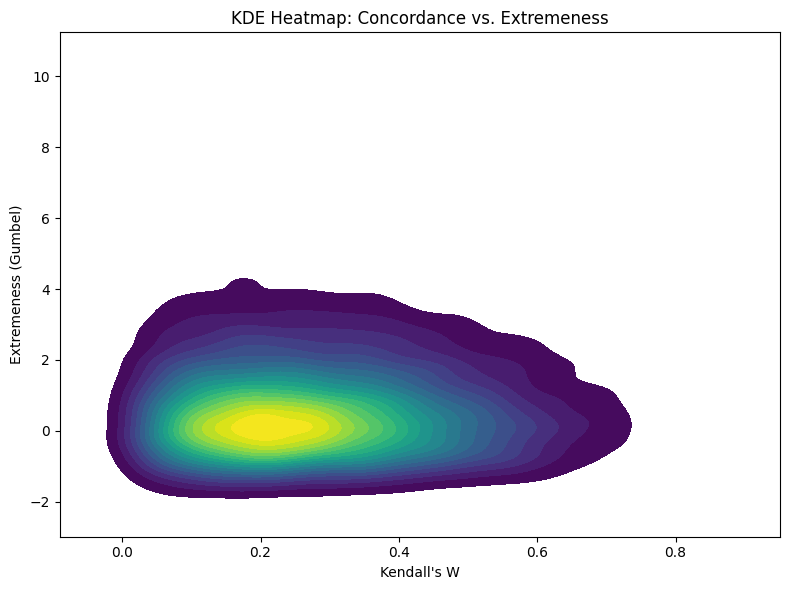

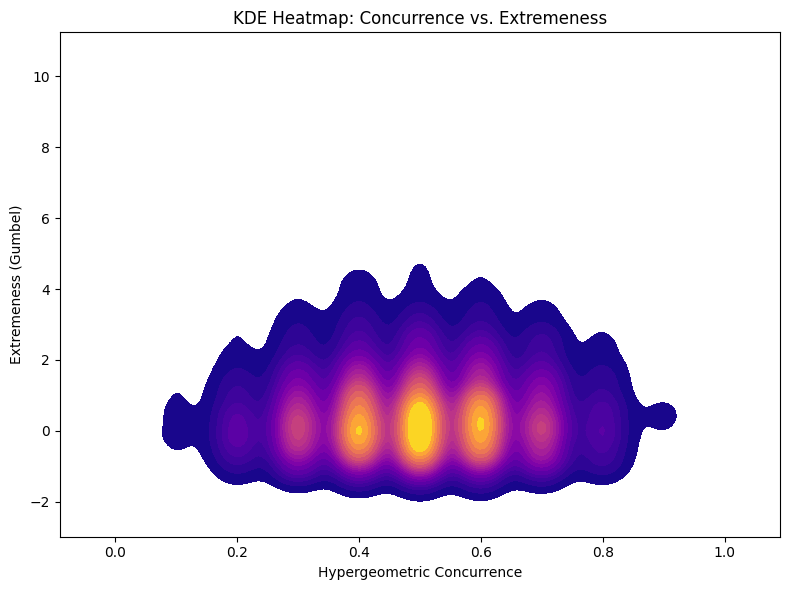

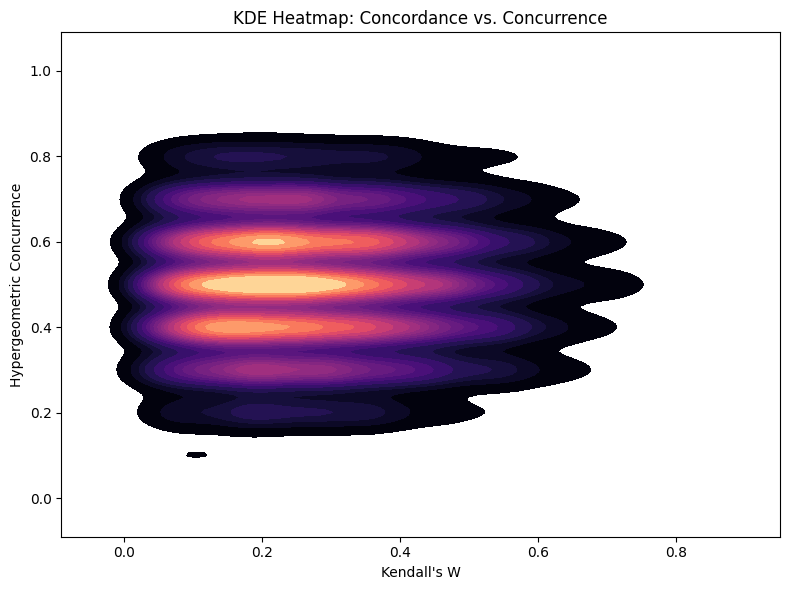

Sample of generated data:
   Kendall_W  Hypergeometric_Concurrence  Extremeness_Gumbel
0   0.353677                         0.4           -0.052815
1   0.248558                         0.7            2.693412
2   0.415959                         0.4            0.252090
3   0.159968                         0.7           -0.716316
4   0.550283                         0.4           -0.825019


In [20]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import gaussian_kde

# Generate Monte Carlo samples
np.random.seed(42)  # for reproducibility
N = 20000  # Number of samples

# Simulate Kendall's W (Concordance) as a beta distribution (approximation)
kendall_w = np.random.beta(a=2, b=5, size=N)  # Adjust shape parameters as needed

# Simulate Hypergeometric Concurrence as a binomial approximation (continuous)
hypergeom_concurrence = np.random.binomial(n=10, p=0.5, size=N) / 10  # Normalized

# Simulate Extremeness using a Gumbel distribution
extremeness_gumbel = np.random.gumbel(loc=0, scale=1, size=N)

# Create a DataFrame for visualization
df = pd.DataFrame({
    'Kendall_W': kendall_w,
    'Hypergeometric_Concurrence': hypergeom_concurrence,
    'Extremeness_Gumbel': extremeness_gumbel
})

# Create 3D KDE for true density visualization
data = np.vstack([df['Kendall_W'], df['Hypergeometric_Concurrence'], df['Extremeness_Gumbel']])
kde = gaussian_kde(data)

# Define the grid size
grid_size = 20

# Create a grid in 3D space
x_min, x_max = df['Kendall_W'].min(), df['Kendall_W'].max()
y_min, y_max = df['Hypergeometric_Concurrence'].min(), df['Hypergeometric_Concurrence'].max()
z_min, z_max = df['Extremeness_Gumbel'].min(), df['Extremeness_Gumbel'].max()

# Create grid with one fewer point than needed for voxels
# voxels needs n+1 points to create n cells
xi, yi, zi = np.mgrid[
    x_min:x_max:complex(grid_size),
    y_min:y_max:complex(grid_size),
    z_min:z_max:complex(grid_size)
]

# Calculate kde on the cell centers
centers_x = (xi[:-1, :-1, :-1] + xi[1:, 1:, 1:]) / 2
centers_y = (yi[:-1, :-1, :-1] + yi[1:, 1:, 1:]) / 2
centers_z = (zi[:-1, :-1, :-1] + zi[1:, 1:, 1:]) / 2

# Reshape for kde evaluation
coords = np.vstack([
    centers_x.ravel(),
    centers_y.ravel(),
    centers_z.ravel()
])

# Calculate density
density = kde(coords).reshape((grid_size-1, grid_size-1, grid_size-1))

# Find the density threshold for the isosurface
density_threshold = np.percentile(density, 70)  # Adjust as needed

# Create the 3D density plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Now voxels should work correctly
ax.voxels(
    xi, yi, zi,
    density > density_threshold,
    facecolors=plt.cm.viridis(density/density.max()),
    edgecolor='none', alpha=0.3
)

# Add scatter points for reference
random_indices = np.random.choice(N, size=500, replace=False)
ax.scatter(
    df['Kendall_W'][random_indices],
    df['Hypergeometric_Concurrence'][random_indices],
    df['Extremeness_Gumbel'][random_indices],
    c='black', s=5, alpha=0.5
)

ax.set_xlabel("Kendall's W (Concordance)")
ax.set_ylabel("Hypergeometric Concurrence")
ax.set_zlabel("Extremeness (Gumbel)")
ax.set_title("3D Density Plot of CCEP Components")

plt.tight_layout()
plt.show()

# Show 2D KDE heatmaps

# Kendall's W vs. Extremeness (Gumbel)
plt.figure(figsize=(8, 6))
sns.kdeplot(x=df["Kendall_W"], y=df["Extremeness_Gumbel"], fill=True, cmap="viridis", levels=20)
plt.xlabel("Kendall's W")
plt.ylabel("Extremeness (Gumbel)")
plt.title("KDE Heatmap: Concordance vs. Extremeness")
plt.tight_layout()
plt.show()

# Hypergeometric Concurrence vs. Extremeness (Gumbel)
plt.figure(figsize=(8, 6))
sns.kdeplot(x=df["Hypergeometric_Concurrence"], y=df["Extremeness_Gumbel"], fill=True, cmap="plasma", levels=20)
plt.xlabel("Hypergeometric Concurrence")
plt.ylabel("Extremeness (Gumbel)")
plt.title("KDE Heatmap: Concurrence vs. Extremeness")
plt.tight_layout()
plt.show()

# Kendall's W vs. Hypergeometric Concurrence
plt.figure(figsize=(8, 6))
sns.kdeplot(x=df["Kendall_W"], y=df["Hypergeometric_Concurrence"], fill=True, cmap="magma", levels=20)
plt.xlabel("Kendall's W")
plt.ylabel("Hypergeometric Concurrence")
plt.title("KDE Heatmap: Concordance vs. Concurrence")
plt.tight_layout()
plt.show()

# Display the generated data
print("Sample of generated data:")
print(df.head())